## Modules Used
Modulo responsável pela comunicação com o CoppeliaSim



In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

Modulos Usados para Nesse trabalho prático



In [ ]:
# Other Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import networkx as nx

## Visualizar o mapa
Uma função que carrega uma imagem e mostra ela em preto e branco e retorna a matriz numpy correspondente à imagem

In [2]:
def visuMapa(arquivo, threshold):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = 1 - mpimg.imread(arquivo)

    # Apenas para garantir que só teremos esses dois valores
    img[img > threshold] = 1
    img[img<= threshold] = 0

    ax.imshow(img, cmap='Greys', origin='upper')
    return img

## Visualizar o mapa com bordas

## Visualizar grid
Função que Discretiza o Ambiente

In [3]:
def visuGrid(img, map_dims, threshold, cell_size):
    # Escala Pixel/Metro
    sy, sx = img.shape / map_dims

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                        
            grid[r, c] = np.sum(img[yi:yf,xi:xf])
            
    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0        

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
    return rows, cols, grid

## Visualizar grafo grid
Transforma o grid em um grafo

In [4]:

def grafoGrid(rows, cols, grid, map_dims, cell_size):
    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 

    # Removendo células que estão em células marcas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:  
                G.remove_node((r,c))


    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    # Os vértices serão plotados no centro da célula  
    pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)
    return G, pos

## Visualizar caminho
Determina o menor caminho entre o ponto de partida do robô e o ponto de chegada

In [5]:
def visuCaminho(grid, map_dims, G, pos, start_node, end_node):
    # Finalmente podemos determinar o menor caminho entre duas células
    # ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    # Caminho
    path = nx.shortest_path(G, source=start_node, target=end_node)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')
    return path

In [6]:
def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

In [7]:
clientID = RemoteAPIClient()
sim = clientID.require('sim')
sim.setStepping(True)

0

In [8]:
def simulacao(path):
    sim.startSimulation()
    print ('Connected to remote API server')

    robotname = '/robotino'
    robotHandle = sim.getObject(robotname)     
    referenceHandle = sim.getObject('/ReferenceFrame')     

    wheel1 = sim.getObject(robotname+'/wheel0_joint')
    wheel2 = sim.getObject(robotname + '/wheel1_joint')
    wheel3 = sim.getObject(robotname + '/wheel2_joint')
                
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
                
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    for node in path:

        # Goal configuration (x, y, theta)    
        qgoal = np.array([node[0], node[1], np.deg2rad(0)])

        # Frame que representa o Goal
        goalFrame = sim.getObject('/Goal')     
        sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0],referenceHandle )
        sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], referenceHandle)

        gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])


        while True:
            pos = sim.getObjectPosition(robotHandle,referenceHandle)        
            ori = sim.getObjectOrientation(robotHandle,referenceHandle)

            q = np.array([pos[0], pos[1], ori[2]])
            
            error = qgoal - q
            
            # Margem aceitável de distância
            if (np.linalg.norm(error[:2]) < 0.05):
                break

            # Controller
            qdot = gain @ error
            
            # Cinemática Inversa
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot

            # Enviando velocidades
            sim.setJointTargetVelocity(wheel1, u[0])
            sim.setJointTargetVelocity(wheel2, u[1])
            sim.setJointTargetVelocity(wheel3, u[2])  

            sim.step()  
                 
        sim.setJointTargetVelocity(wheel1, 0)
        sim.setJointTargetVelocity(wheel2, 0)
        sim.setJointTargetVelocity(wheel3, 0)
        
    # Now close the connection to CoppeliaSim:
    sim.stopSimulation()

        
    print ('Program ended')

In [9]:
threshold = 0.5
cell_size = 1
start_node =  (1, 1)
end_node = (20, 20)
map_dims = np.array([30, 30])  


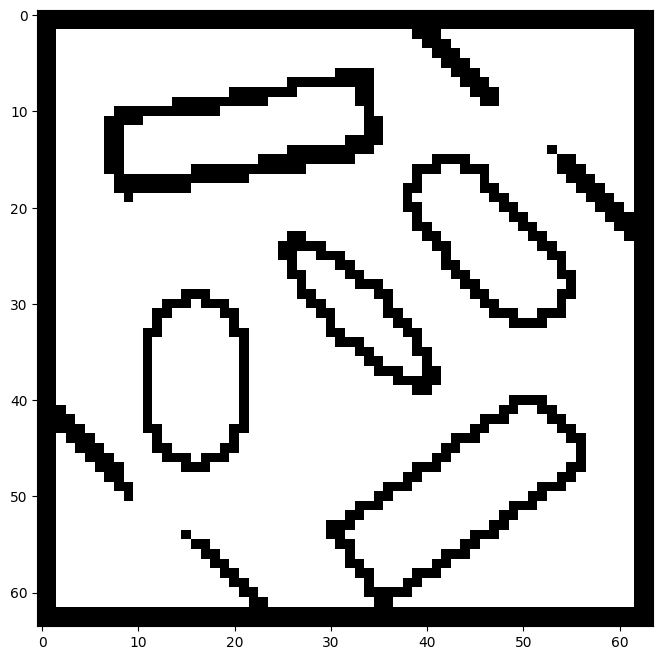

In [10]:
img = visuMapa('mapas/mapa1invertido.png', threshold)

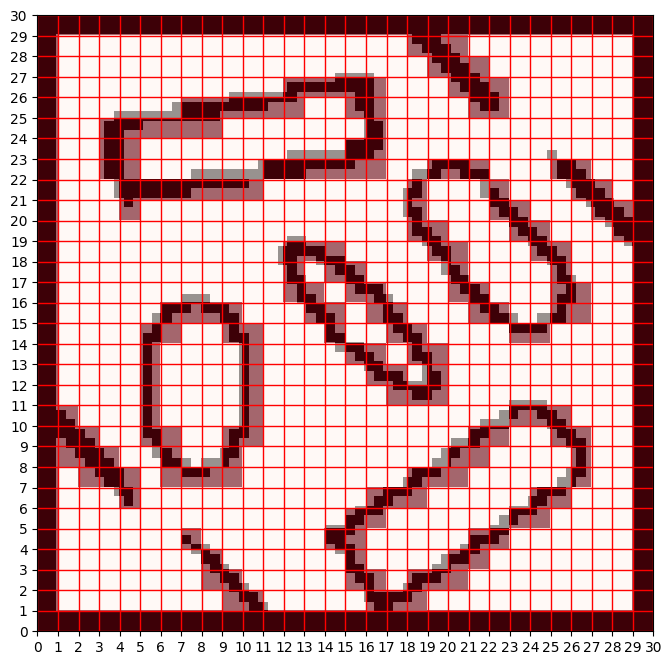

In [11]:
rows, cols, grid, = visuGrid(img, map_dims, threshold, cell_size)


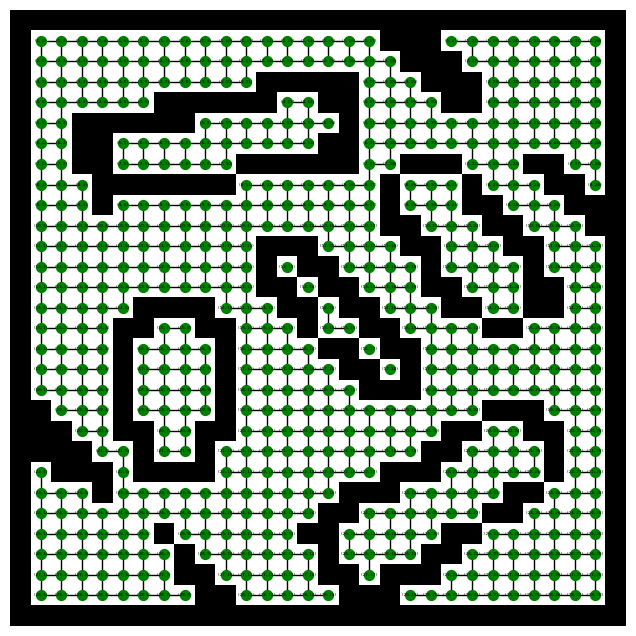

In [12]:
G, pos = grafoGrid(rows, cols, grid, map_dims, cell_size)



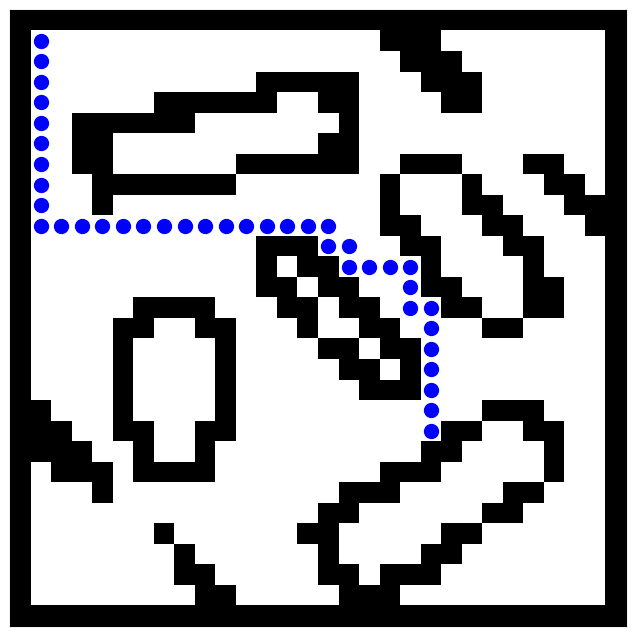

In [13]:
path = visuCaminho(grid, map_dims, G, pos, start_node, end_node)



In [14]:
scenesFolder = "/Users/raphaHausen/tp2/scenes"
selectedScene = "mapa1.ttt"

# An exemple of how to use the api to connet to coppelia
sim.loadScene(os.path.join(scenesFolder, selectedScene)+"@keepCurrent")
simulacao(path)

Connected to remote API server
Program ended
